In [1]:
!which python

/mnt/netapp2/Store_uni/home/ulc/cursos/curso341/mypython/bin/python


# CIFAR-100 Image Classification using ResNet (Residual Network) in PyTorch

ResNet, short for Residual Network is a specific type of neural network that was introduced in 2015 by Kaiming He, Xiangyu Zhang, Shaoqing Ren and Jian Sun in their paper [“Deep Residual Learning for Image Recognition”](https://arxiv.org/pdf/1512.03385.pdf). <br/>
ResNet was an innovative approach over VGG-like models:
* Won 1st place in the ILSVRC 2015 classification competition with a top-5 error rate of 3.57% (An ensemble model)
* Won the 1st place in ILSVRC and COCO 2015 competition in ImageNet Detection, ImageNet localization, Coco detection and Coco segmentation.
* Replacing VGG-16 layers in Faster R-CNN with ResNet-101. They observed relative improvements of 28%
* Efficiently trained networks with 100 layers and 1000 layers also.

We get over 70% accuracy without using any pre-trained model in 100 epochs and it proves the power of ResNet.

In this notebook, I will be implementing less complex version of ResNets to be able to get results in reasonable amount of time. Even though the implementation is done through CIFAR-100 dataset, it can be used with any image classification dataset. <br/>Note: Do not forget to change transform values if you use different the dataset. You can find the best parameters from SOTA implementations for well-known datasets.

#### References which I got implementations and explanations.
- [weiaicunzai/pytorch-cifar100](https://github.com/weiaicunzai/pytorch-cifar100/blob/master/models/resnet.py)
- [papers-with-code](https://paperswithcode.com/sota/image-classification-on-cifar-100)
- [pytorch-basic-cifar10](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)
- [more-implementation-with-explanations](https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1)
- [more-reading](https://www.researchgate.net/publication/355698607_MEST_Accurate_and_Fast_Memory-Economic_Sparse_Training_Framework_on_the_Edge)
- [visualization](https://jovian.ai/damian-c036/cifar100-final-project/v/5?utm_source=embed)


So we are good to go.


# Necessary Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR100
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split, ConcatDataset
import torchvision.transforms as tt
import random
import torch.nn.utils.prune as prune
import copy
import time
import zipfile

____
#### Before we load the data, it is required to first prepare the transformations to be applied. It is an important step to prepare the data for training to avoid overfitting problem.
____

In [3]:
stats = ((0.5074,0.4867,0.4411),(0.2011,0.1987,0.2025))
train_transform = tt.Compose([
    tt.RandomHorizontalFlip(),
    tt.RandomCrop(32, padding=4, padding_mode="reflect"),
    tt.ToTensor(),
    tt.Normalize(*stats)
])

test_transform = tt.Compose([
    tt.ToTensor(),
    tt.Normalize(*stats)
])

___
RandomHorizontalFlip randomly flips an image with a probability of 50%, and RandomCrop pads an image by 4 pixel on each side then randomly crops 32x32 from the image after padding. We add such transformations to add noise to the data and prevent our model from overfitting. There are also other transformations you can use such as ColorJitter and RandomVerticalFlip etc. but I found these to be sufficient for our purposes. <br />

ToTensor simply converts the image to a Tensor. Since its a coloured image, it would have 3 channels (R,G,B) so the Tensor would be of size 3x32x32. <br/>

Normalize takes the mean and standard deviation for each channel of the entire dataset as input. Normalizing scales our data to a similar range of values to make sure that our gradients don’t go out of control.
Now we just prepare our train and test dataset and then we can explore the data.
___

# Loading Data

In [4]:
path = "dataset"
train_data = CIFAR100(download=True, root=path, transform=train_transform)
test_data = CIFAR100(root=path, train=False, transform=test_transform)

_____

In [5]:
for image, label in train_data:
    print("Image shape: ",image.shape)
    print("Image tensor: ", image)
    print("Label: ", label)
    break

Image shape:  torch.Size([3, 32, 32])
Image tensor:  tensor([[[ 1.6890,  1.3380,  0.7920,  ...,  2.4300,  2.4300,  2.4300],
         [ 2.1960,  1.9425,  1.2795,  ...,  2.4495,  2.4495,  2.4495],
         [ 1.6890,  1.3380,  0.7920,  ...,  2.4300,  2.4300,  2.4300],
         ...,
         [-0.2026, -1.0216, -1.5676,  ...,  0.4995,  0.6945,  0.5385],
         [-0.3976, -1.6846, -1.9381,  ..., -0.3976, -0.1246,  0.2070],
         [-0.7486, -1.9381, -2.0941,  ..., -0.3196, -0.6316, -0.7096]],

        [[ 2.0307,  1.7149,  1.0241,  ...,  2.5636,  2.5636,  2.5636],
         [ 2.5241,  2.2872,  1.5965,  ...,  2.5833,  2.5833,  2.5833],
         [ 2.0307,  1.7149,  1.0241,  ...,  2.5636,  2.5636,  2.5636],
         ...,
         [-0.3179, -1.2258, -1.7784,  ...,  1.3202,  1.4583,  1.3004],
         [-0.4166, -1.8179, -2.1139,  ...,  0.4321,  0.6492,  1.0044],
         [-0.6534, -2.0547, -2.1336,  ...,  0.5110,  0.1755,  0.0965]],

        [[ 2.1209,  1.5787,  0.7266,  ...,  2.7406,  2.7406,  2

# BATCHSIZE & DataLoader

In [6]:
BATCH_SIZE = 128
train_dl = DataLoader(train_data, BATCH_SIZE, num_workers=4, pin_memory=True, shuffle=False)
test_dl = DataLoader(test_data, BATCH_SIZE, num_workers=4, pin_memory=True, shuffle=False)

# Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7420608..1.88].


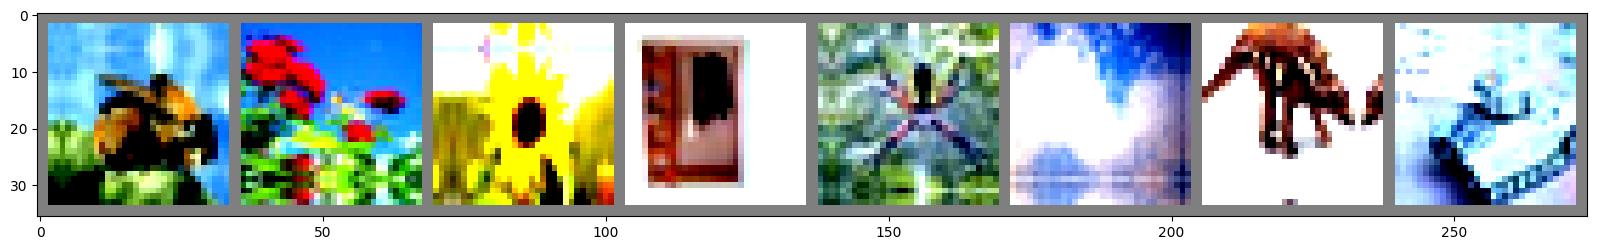

bee                 rose                sunflower           wardrobe            spider              cloud               dinosaur            tank                


In [7]:
# for 8 images
train_8_samples = DataLoader(train_data, 8, num_workers=4, pin_memory=True, shuffle=True)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize = (20,20))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_8_samples)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print(''.join(f'{train_data.classes[labels[j]]:20s}' for j in range(8)))

# Get CUDA ready

In [8]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)


class ToDeviceLoader:
    def __init__(self,data,device):
        self.data = data
        self.device = device
        
    def __iter__(self):
        for batch in self.data:
            yield to_device(batch,self.device)
            
    def __len__(self):
        return len(self.data)


In [9]:
device = get_device()
print(device)

train_dl = ToDeviceLoader(train_dl, device)
test_dl = ToDeviceLoader(test_dl, device)

cuda


In [10]:
def accuracy(predicted, actual):
    _, predictions = torch.max(predicted, dim=1)
    return torch.tensor(torch.sum(predictions==actual).item()/len(predictions))

# BaseModel

In [11]:
class BaseModel(nn.Module):
    def training_step(self,batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        return loss
    
    def validation_step(self,batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        acc = accuracy(out,labels)
        return {"val_loss":loss.detach(),"val_acc":acc}
    
    def validation_epoch_end(self,outputs):
        batch_losses = [loss["val_loss"] for loss in outputs]
        loss = torch.stack(batch_losses).mean()
        batch_accuracy = [accuracy["val_acc"] for accuracy in outputs]
        acc = torch.stack(batch_accuracy).mean()
        return {"val_loss":loss.item(),"val_acc":acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

# ResNet Implementation

BaseModel allows us to check and record the results of our model every time we train and pretty much just helps us keep track of our progress. This is what our actual model will inherit. <br />

I implemented ResNet with changing a little bit that worked better than the one I got and used as base.<br />

#### An example figure of ResNet approach to understand easily what we will see below as code:

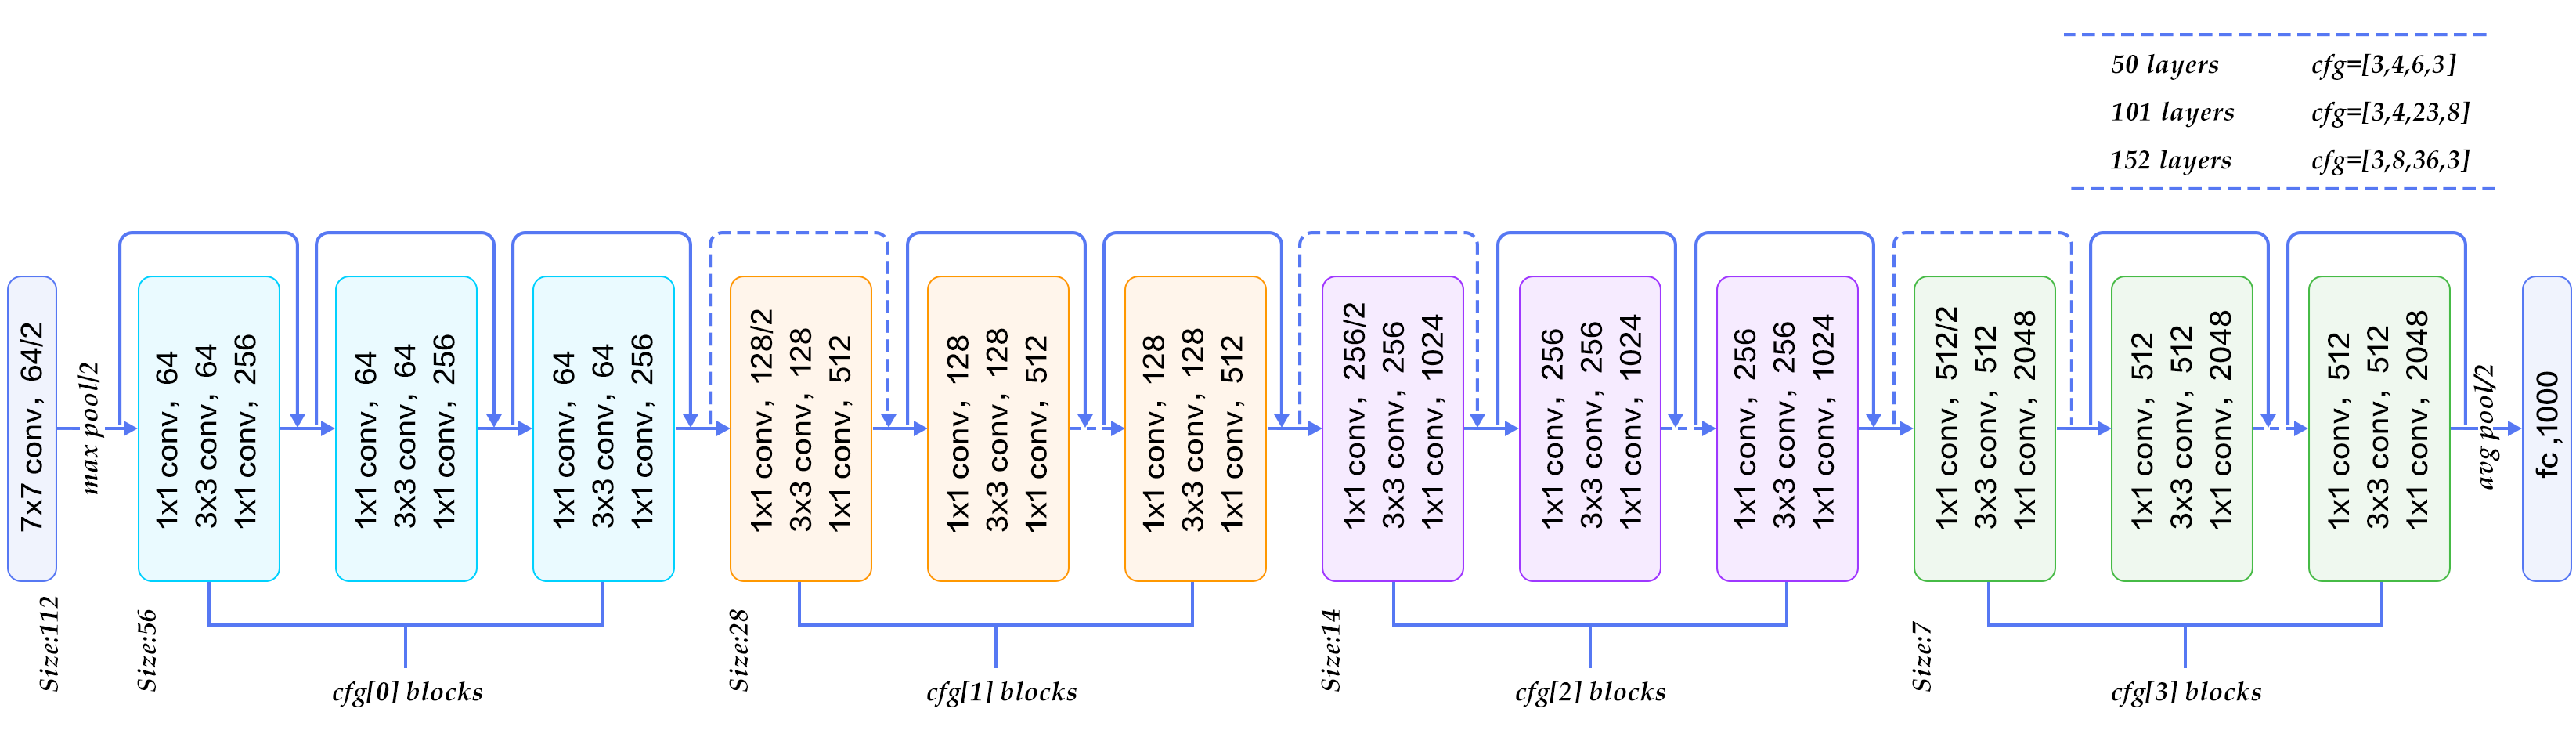
<br/><br/><br/><br/>
____



In [12]:
def conv_shortcut(in_channel, out_channel, stride):
    layers = [nn.Conv2d(in_channel, out_channel, kernel_size=(1,1), stride=(stride, stride)),
             nn.BatchNorm2d(out_channel)]
    return nn.Sequential(*layers)

def block(in_channel, out_channel, k_size,stride, conv=False):
    layers = None
    
    first_layers = [nn.Conv2d(in_channel,out_channel[0], kernel_size=(1,1),stride=(1,1)),
                    nn.BatchNorm2d(out_channel[0]),
                    nn.ReLU(inplace=True)]
    if conv:
        first_layers[0].stride=(stride,stride)
    
    second_layers = [nn.Conv2d(out_channel[0], out_channel[1], kernel_size=(k_size, k_size), stride=(1,1), padding=1),
                    nn.BatchNorm2d(out_channel[1])]

    layers = first_layers + second_layers
    
    return nn.Sequential(*layers)
    

class ResNet(BaseModel):
    
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.stg1 = nn.Sequential(
                                   nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=(3),
                                             stride=(1), padding=1),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU(inplace=True),
                                   nn.MaxPool2d(kernel_size=3, stride=2))
        
        ##stage 2
        self.convShortcut2 = conv_shortcut(64,256,1)
        
        self.conv2 = block(64,[64,256],3,1,conv=True)
        self.ident2 = block(256,[64,256],3,1)

        
        ##stage 3
        self.convShortcut3 = conv_shortcut(256,512,2)
        
        self.conv3 = block(256,[128,512],3,2,conv=True)
        self.ident3 = block(512,[128,512],3,2)

        
        ##stage 4
        self.convShortcut4 = conv_shortcut(512,1024,2)
        
        self.conv4 = block(512,[256,1024],3,2,conv=True)
        self.ident4 = block(1024,[256,1024],3,2)
        
        
        ##Classify
        self.classifier = nn.Sequential(
                                       nn.AvgPool2d(kernel_size=(4)),
                                       nn.Flatten(),
                                       nn.Linear(1024, num_classes))
        
    def forward(self,inputs):
        out = self.stg1(inputs)
        
        #stage 2
        out = F.relu(self.conv2(out) + self.convShortcut2(out))
        out = F.relu(self.ident2(out) + out)
        out = F.relu(self.ident2(out) + out)
        out = F.relu(self.ident2(out) + out)
        
        #stage3
        out = F.relu(self.conv3(out) + (self.convShortcut3(out)))
        out = F.relu(self.ident3(out) + out)
        out = F.relu(self.ident3(out) + out)
        out = F.relu(self.ident3(out) + out)
        out = F.relu(self.ident3(out) + out)
        
        #stage4             
        out = F.relu(self.conv4(out) + (self.convShortcut4(out)))
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        
        #Classify
        out = self.classifier(out)#100x1024
        
        return out
        

# Evaluation & Fit Function for Training

In [13]:
@torch.no_grad()
def evaluate(model,test_dl):
    model.eval()
    outputs = [model.validation_step(batch) for batch in test_dl]
    return model.validation_epoch_end(outputs)

In [14]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit (epochs, train_dl, test_dl, model, optimizer, max_lr, weight_decay, scheduler, grad_clip=None):
    torch.cuda.empty_cache()
    
    history = []
    
    optimizer = optimizer(model.parameters(), max_lr, weight_decay = weight_decay)
    
    scheduler = scheduler(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_dl))
    
    for epoch in range(epochs):
        model.train()
        
        train_loss = []
        
        lrs = []
        
        for batch in train_dl:
            loss = model.training_step(batch)
            
            train_loss.append(loss)
            
            loss.backward()
            
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            scheduler.step()
            lrs.append(get_lr(optimizer))
        result = evaluate(model, test_dl)
        result["train_loss"] = torch.stack(train_loss).mean().item()
        result["lrs"] = lrs
        
        model.epoch_end(epoch,result)
        history.append(result)
        
    return history
            

# Hyperparameters

- **max_lr**: is the maximum learning rate that we set for learning rate scheduler. For the learning rate scheduler we used OneCycleLR, which sets the learning rate to a low learning rate, gradually increases it to the max learning rate then goes back to a low learning rate. <br/>
- **grad_clip**: prevents the gradients to become too large. <br/>
- **weight_decay**: essentially tries to make the model simple and helps the model generalise better.


In [15]:
epochs = 10
optimizer = torch.optim.Adam
max_lr = 1e-3
grad_clip = 0.1
weight_decay = 1e-5
scheduler = torch.optim.lr_scheduler.OneCycleLR

# Training

In [16]:
print("device:", device)

device: cuda


In [17]:
model = ResNet(3,100)
model = to_device(model, device)

In [18]:
%%time
history = fit(epochs=epochs, train_dl=train_dl, test_dl=test_dl, model=model, 
              optimizer=optimizer, max_lr=max_lr, grad_clip=grad_clip,
              weight_decay=weight_decay, scheduler=torch.optim.lr_scheduler.OneCycleLR)

Epoch [0], last_lr: 0.00028, train_loss: 3.8595, val_loss: 3.9783, val_acc: 0.1104
Epoch [1], last_lr: 0.00076, train_loss: 3.2432, val_loss: 3.6060, val_acc: 0.1718
Epoch [2], last_lr: 0.00100, train_loss: 2.8428, val_loss: 3.0075, val_acc: 0.2510
Epoch [3], last_lr: 0.00095, train_loss: 2.3792, val_loss: 2.6946, val_acc: 0.3167
Epoch [4], last_lr: 0.00081, train_loss: 2.0417, val_loss: 2.4125, val_acc: 0.3742
Epoch [5], last_lr: 0.00061, train_loss: 1.7713, val_loss: 2.2800, val_acc: 0.4034
Epoch [6], last_lr: 0.00039, train_loss: 1.5383, val_loss: 2.0864, val_acc: 0.4521
Epoch [7], last_lr: 0.00019, train_loss: 1.3094, val_loss: 1.8538, val_acc: 0.4994
Epoch [8], last_lr: 0.00005, train_loss: 1.0980, val_loss: 1.6609, val_acc: 0.5411
Epoch [9], last_lr: 0.00000, train_loss: 0.9521, val_loss: 1.6139, val_acc: 0.5526
CPU times: user 1min 12s, sys: 18.8 s, total: 1min 31s
Wall time: 1min 32s


# Pruning

Dans un premier temps, on va appliquer le pruning succesivement sur les différentes couches du modèles.

In [19]:
def get_model_size(model, file_name="temp.pth"):
    """Save the model temporarily and measure its size."""
    torch.save(model.state_dict(), file_name)
    size = os.path.getsize(file_name)
    os.remove(file_name)  # Remove temp file
    return size

def save_model(model, model_name, save_dir="models"):
    """Save the model in the specified directory."""
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)  # Create the directory if it doesn't exist

    save_path = os.path.join(save_dir, model_name)
    torch.save(model.state_dict(), save_path)
    print(f"Model saved at {save_path}")

def evaluate_model(model, test_dl):
    """Function to evaluate the model's accuracy on the test set."""
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dl:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

def predict_image(img, model):
    start_time = time.time()

    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)

    end_time = time.time()

    inference_time = end_time - start_time
    return inference_time, test_data.classes[preds[0].item()]

def inference_time(model, test_data, num_images=None):
    if not num_images:
        num_images = len(test_data)
    total_inference_time = 0
    for i in range(num_images):
        img, label = test_data[i]
        inference_time, predicted_class = predict_image(img, model)        
        total_inference_time += inference_time

    average_inference_time = total_inference_time / num_images
    return average_inference_time

In [20]:
def apply_pruning_globally(model, amount=0.3, remove=False):
    """
    Apply pruning globally to all Conv2d and Linear layers in the model.

    Args:
        model (torch.nn.Module): The PyTorch model to prune.
        amount (float): The proportion of connections to prune.
        remove (bool): If True, removes the pruning reparameterization.

    Returns:
        torch.nn.Module: The pruned model.
    """    
    parameters_to_prune = []
    for module in model.modules():
        if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
            parameters_to_prune.append((module, 'weight'))

    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=amount
    )
    
    if remove:
        for module, name in parameters_to_prune:
            prune.remove(module, name) # (module, weights)

    return model

def apply_pruning_locally(model, amount=0.3, remove=False):
    """
    Apply pruning locally to Conv2d and Linear layers in the model.

    Args:
        model (torch.nn.Module): The PyTorch model to prune.
        amount (float): The proportion of connections to prune.
        remove (bool): If True, removes the pruning reparameterization.

    Returns:
        torch.nn.Module: The pruned model.
    """    
    for module in model.modules():
        if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
            prune.l1_unstructured(module, name='weight', amount=amount)
            if remove:
                prune.remove(module, 'weight')
    return model

In [21]:
def plot_pruning_performance(pruning_rates, accuracies, pruning_sizes, average_inference_times):
    """Plot pruning performance graphs separately for accuracy and size."""
    
    # Convert model size to MB
    pruning_sizes_mb = [size / (1024 * 1024) for size in pruning_sizes]
    
    # Plot accuracy vs. pruning rate
    plt.figure(figsize=(10, 5))
    plt.plot(pruning_rates, accuracies, marker='o', linestyle='-', color='tab:blue', label='Test Accuracy')
    plt.xlabel('Pruning Rate (%)')
    plt.ylabel('Test Accuracy')
    plt.title('Test Accuracy vs. Pruning Rate')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # Plot model size vs. pruning rate
    plt.figure(figsize=(10, 5))
    plt.plot(pruning_rates, pruning_sizes_mb, marker='o', linestyle='-', color='tab:red', label='Model Size')
    plt.xlabel('Pruning Rate (%)')
    plt.ylabel('Model Size (MB)')
    plt.title('Model Size vs. Pruning Rate')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot inference time vs. pruning rate
    plt.figure(figsize=(10, 5))
    plt.plot(pruning_rates, average_inference_times, marker='o', linestyle='-', color='tab:red', label='Model Size')
    plt.xlabel('Pruning Rate (%)')
    plt.ylabel('Inference Time (s)')
    plt.title('Inference Time vs. Pruning Rate')
    plt.grid(True)
    plt.legend()
    plt.show()

def evaluate_pruning(model, pruning_rates, test_dl, test_data, apply_pruning_func=apply_pruning_locally):
    """Evaluate different pruning rates and display model size and performance."""
    # Store original model size and accuracy
    original_size = get_model_size(model)
    
    # Store original model accuracy
    original_model = model
    original_model.eval()
    original_test_acc = evaluate(original_model, test_dl)

    print("\n==== Model Size Comparison ====")
    print("Original model size: {:.2f} MB".format(original_size / (1024 * 1024)))
    print("Original Test Accuracy:", original_test_acc)

    # Store the pruning rates and their corresponding accuracies and sizes for plotting
    pruning_accuracies = []
    pruning_sizes = []
    average_inference_times = []
    # Iterate through different pruning rates
    for rate in pruning_rates:
        print(f"\n==== Pruning Rate: {rate * 100:.0f}% ====")
        
        # Apply pruning
        pruned_model = apply_pruning_func(model, amount=rate, remove=True)

        # Measure pruned model size
        pruned_size = get_model_size(pruned_model)
        
        # Evaluate pruned model
        pruned_model.eval()
        pruned_test_acc = evaluate_model(pruned_model, test_dl)
        average_inference_time = inference_time(pruned_model, test_data, 1000)
        # Display results
        print(f"Pruned model size: {pruned_size / (1024 * 1024):.2f} MB")
        print(f"Pruned Test Accuracy: {pruned_test_acc:.2f}")
        print(f"Pruned Test Inference Time: {average_inference_time:.8f}")
        
        # Save pruned model with unique name based on pruning rate
        #save_model(pruned_model, f"pruned_model_{int(rate * 100)}.pth")
        
        # Append the accuracy and size to the lists for plotting
        pruning_accuracies.append(pruned_test_acc)
        pruning_sizes.append(pruned_size)
        average_inference_times.append(average_inference_time)
    
    return pruning_accuracies, pruning_sizes, average_inference_times


==== Model Size Comparison ====
Original model size: 28.69 MB
Original Test Accuracy: {'val_loss': 1.613916277885437, 'val_acc': 0.5526107549667358}

==== Pruning Rate: 0% ====
Pruned model size: 28.69 MB
Pruned Test Accuracy: 0.55
Pruned Test Inference Time: 0.00472727

==== Pruning Rate: 10% ====
Pruned model size: 28.69 MB
Pruned Test Accuracy: 0.55
Pruned Test Inference Time: 0.00483373

==== Pruning Rate: 20% ====
Pruned model size: 28.69 MB
Pruned Test Accuracy: 0.50
Pruned Test Inference Time: 0.00477253

==== Pruning Rate: 30% ====
Pruned model size: 28.69 MB
Pruned Test Accuracy: 0.31
Pruned Test Inference Time: 0.00467558

==== Pruning Rate: 40% ====
Pruned model size: 28.69 MB
Pruned Test Accuracy: 0.17
Pruned Test Inference Time: 0.00481645

==== Pruning Rate: 50% ====
Pruned model size: 28.69 MB
Pruned Test Accuracy: 0.06
Pruned Test Inference Time: 0.00470241

==== Pruning Rate: 60% ====
Pruned model size: 28.69 MB
Pruned Test Accuracy: 0.02
Pruned Test Inference Time: 0

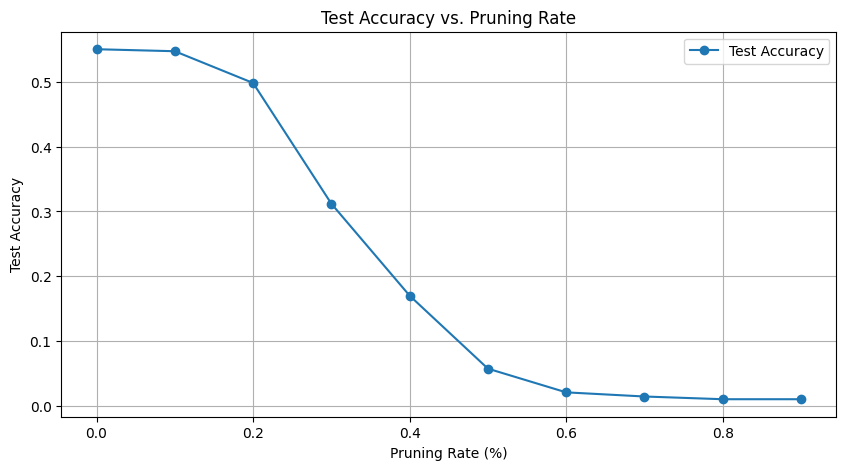

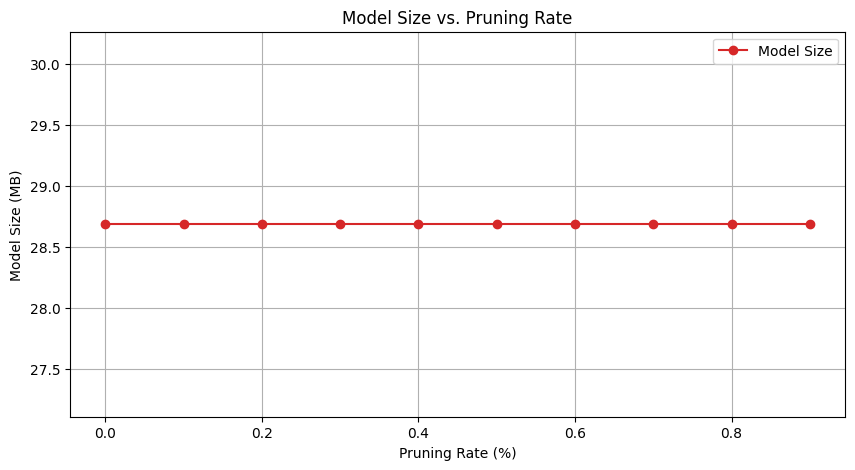

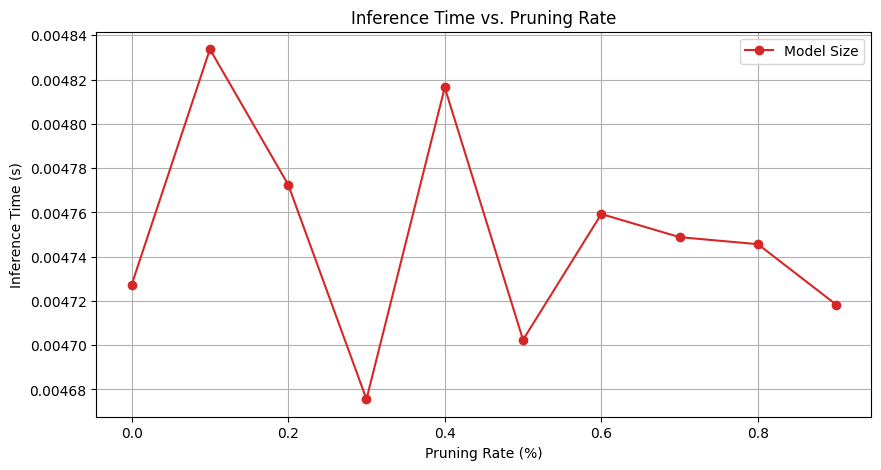

In [22]:
pruning_rates = [0.1*k for k in range(0, 10)]
model_copy = copy.deepcopy(model)
pruning_accuracies, pruning_sizes, average_inference_times = evaluate_pruning(model_copy, pruning_rates, test_dl, test_data, apply_pruning_locally)
plot_pruning_performance(pruning_rates, pruning_accuracies, pruning_sizes, average_inference_times)

D'après les résultats, on observe que:
- l'accuracy sur le dataset de validation ne diminue jusqu'a un pruning de 0.1
- la taille du modèle ne change pas, cela est due au fait que les différents poids du modèles ne sont pas supprimé mais modifié à 0, l'architecture du modèle est donc maintenue, un format de sauvegarde particulié adapté pourrait améliorer le stockage en réduisant la taille du modèle. Dans ce cas si, on aurait alors un diminution presque linéaire de la taille du modèle.
- on observe en moyenne pas de différences significatives entre les temps d'inférences pour 1000 images

Dans un seccond temps, on va appliquer le pruning de manière globale sur tout le modèle.


==== Model Size Comparison ====
Original model size: 28.69 MB
Original Test Accuracy: {'val_loss': 1.613916277885437, 'val_acc': 0.5526107549667358}

==== Pruning Rate: 0% ====


Pruned model size: 28.69 MB
Pruned Test Accuracy: 0.55
Pruned Test Inference Time: 0.00471243

==== Pruning Rate: 10% ====
Pruned model size: 28.69 MB
Pruned Test Accuracy: 0.55
Pruned Test Inference Time: 0.00471846

==== Pruning Rate: 20% ====
Pruned model size: 28.69 MB
Pruned Test Accuracy: 0.55
Pruned Test Inference Time: 0.00472739

==== Pruning Rate: 30% ====
Pruned model size: 28.69 MB
Pruned Test Accuracy: 0.54
Pruned Test Inference Time: 0.00472209

==== Pruning Rate: 40% ====
Pruned model size: 28.69 MB
Pruned Test Accuracy: 0.51
Pruned Test Inference Time: 0.00473287

==== Pruning Rate: 50% ====
Pruned model size: 28.69 MB
Pruned Test Accuracy: 0.44
Pruned Test Inference Time: 0.00474093

==== Pruning Rate: 60% ====
Pruned model size: 28.69 MB
Pruned Test Accuracy: 0.32
Pruned Test Inference Time: 0.00474544

==== Pruning Rate: 70% ====
Pruned model size: 28.69 MB
Pruned Test Accuracy: 0.14
Pruned Test Inference Time: 0.00471631

==== Pruning Rate: 80% ====
Pruned model siz

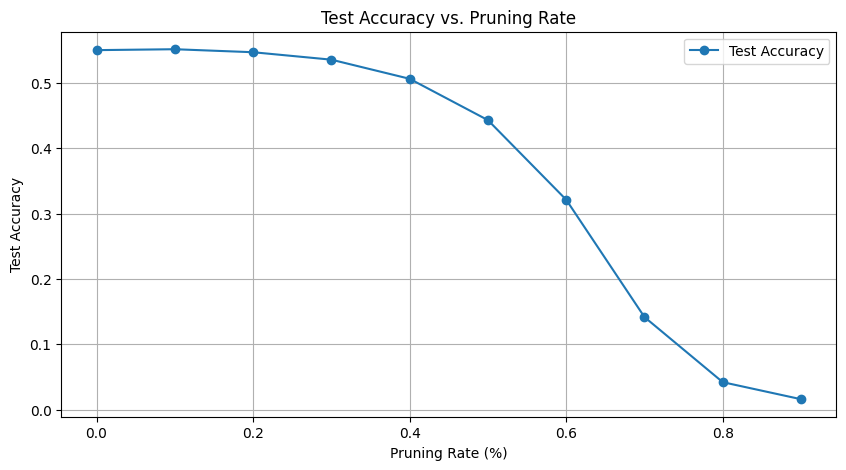

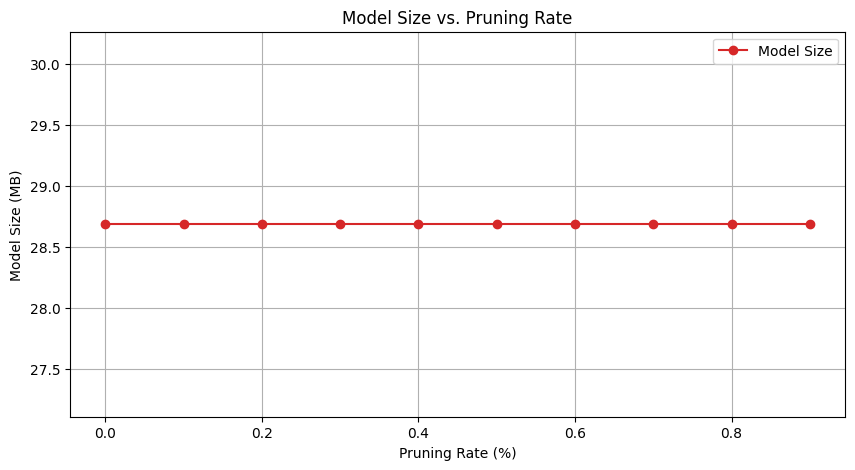

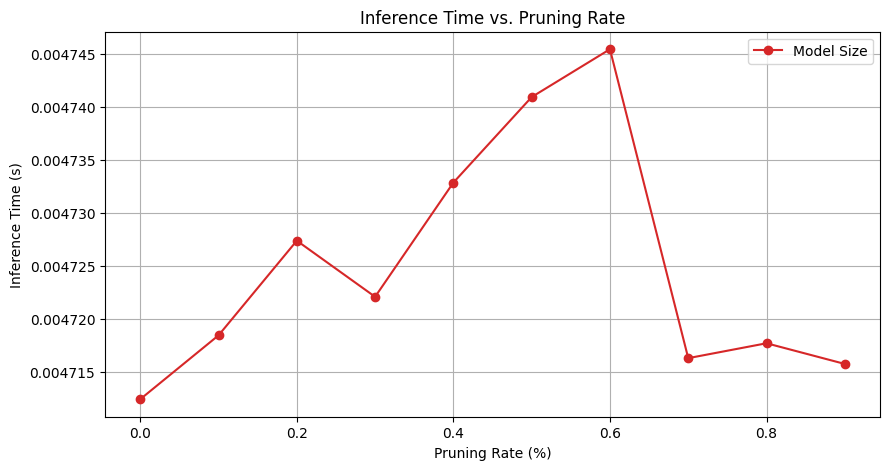

In [23]:
pruning_rates = [0.1*k for k in range(0, 10)]
model_copy = copy.deepcopy(model)
pruning_accuracies, pruning_sizes, average_inference_times = evaluate_pruning(model_copy, pruning_rates, test_dl, test_data, apply_pruning_globally)
plot_pruning_performance(pruning_rates, pruning_accuracies, pruning_sizes, average_inference_times)

D'après les résultats, on observe que:
- l'accuracy sur le dataset de validation ne diminue qu'a partir pruning de 0.2 et ne présente pas un diminution signification pour 0.3 des poids.
- de manière similaire à la preccédente approche, la taille du modèle ne change pas.
- de manière similaire à la preccédente approceh, on observe en moyenne pas de différences significatives entre les temps d'inférences pour 1000 images.

Supprimer les poids les plus faible du modèle en entier plutôt que par couche semble être une meilleur approche car elle permet de garder des performance élevés tout en réduisant la taille théorique du modèle.

# Quantification

In [32]:
import torch
import torch.quantization

def apply_quantization(model, train_dl, backend='fbgemm'):
    model.eval()
    model.qconfig = torch.ao.quantization.QConfig(
        activation=torch.ao.quantization.MinMaxObserver.with_args(dtype=torch.quint8),
        weight=torch.ao.quantization.MinMaxObserver.with_args(dtype=torch.qint8, qscheme=torch.per_tensor_affine)
    )
    torch.quantization.prepare(model, inplace=True)

    # Calibration : passer quelques batchs
    for inputs, labels in train_dl:
        model(inputs)

    torch.quantization.convert(model, inplace=True)
    return model

In [33]:
model_copy = copy.deepcopy(model)
quantified_model = apply_quantization(model_copy, train_dl)

In [ ]:
def apply_dynamic_quantization(model):
    """
    Applies dynamic quantization to a PyTorch model.
    
    Args:
        model (torch.nn.Module): The PyTorch model to quantize.
    
    Returns:
        torch.nn.Module: The dynamically quantized model.
    """
    quantized_model = torch.quantization.quantize_dynamic(
        model, 
        {torch.nn.Linear},  # Cible uniquement les couches linéaires
        dtype=torch.qint8  # Réduction en int8
    )
    return quantized_model